# Modeling with TensorFlow


In [0]:
# get colab status
try:
  import google.colab
  IN_COLAB = True
  %tensorflow_version 2.x
except:
  IN_COLAB = False

In [7]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.utils.data_utils import Sequence # to fix 'imagedatagenerator has no shape' error
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import random, math

In [0]:
if IN_COLAB:
    tf.test.gpu_device_name()
    # need to use gpu runtime accelerator!
    mirrored_strategy = tf.distribute.MirroredStrategy()

# Create generator


In [10]:
!pwd

/content


In [11]:
if IN_COLAB:
    os.chdir(r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/images/')
else:
    os.chdir(os.path.expanduser(r'~/Google Drive/thinkful/colab_datasets/sidewalk_data/images/'))
!pwd

/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/images


In [0]:
#move images into train, test, validate folders with subfolders for classes
test_ratio = .15
SPLIT_DATA = False # switch if need to divide out data
if SPLIT_DATA:
    for label in ['sidewalk', 'no_sidewalk']:
        %cd ./$label
        listing = os.popen('ls').read().strip().split(sep='\n')
        random.shuffle(listing) #inplace
        im_count = len(listing)
        test_size=val_size = math.ceil(test_ratio*im_count)
        train_size = im_count - test_size
        subfolders = ['train', 'test'] #train will be used for vdation too
        for subfolder in subfolders:
            new_path=os.path.join(
                os.path.dirname(os.getcwd()), subfolder, label)
            if not os.path.exists(new_path):
                os.makedirs(new_path)
        for item in range(0, train_size):
            moved = listing.pop()
            !mv $moved ../train/$label/$moved
        for item in range(0, test_size):
            moved = listing.pop()
            !mv $moved ../test/$label/$moved
        %cd ..
        !rmdir ./$label

### Parameters for data loading

In [0]:
idg_params={'rescale': 1./255}
batch_size=64
augmentation_params = {'rotation_range': 15,
                        'zoom_range': 0.15,
                         'width_shift_range': 0.2,
                         'height_shift_range': 0.2,
                         'shear_range': 0.15,
                         'fill_mode': 'nearest',
                         'horizontal_flip': True}
datagen_params = {'batch_size': batch_size,
                  'target_size': (224, 224),
                  'color_mode': 'rgb', 
                  'class_mode': 'binary'}

In [0]:
train_vdate_datagen = ImageDataGenerator(
    **idg_params,
    validation_split=0.2)
train_augmented_datagen = ImageDataGenerator(
    **idg_params,
    **augmentation_params,
    validation_split=0.2)
test_datagen = ImageDataGenerator(**idg_params)

In [15]:
# Flow training images in batches of 128 using train_datagen generator
vdate_generator = train_vdate_datagen.flow_from_directory(
        directory=r'./train/',
        subset='validation',
        **datagen_params)
train_generator = train_vdate_datagen.flow_from_directory(
        directory=r'./train/',
        subset='training',
        **datagen_params)
test_generator = test_datagen.flow_from_directory(
        directory=r'./test/',
        **datagen_params)

Found 832 images belonging to 2 classes.
Found 3335 images belonging to 2 classes.
Found 1230 images belonging to 2 classes.


### Parameters for Modeling

In [0]:
n_epochs = 50
learning_rate = 0.000_001
loss = 'binary_crossentropy'

In [17]:
pwd

'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/images'

In [22]:
imagecount = {}
sidewalk_image_count = ! cd ./train/sidewalk/ && ls | wc -l
no_sidewalk_image_count = ! cd ./train/no_sidewalk/ && ls | wc -l
imagecount['sidewalk'] = int(sidewalk_image_count.nlstr)
imagecount['no_sidewalk'] = int(no_sidewalk_image_count.nlstr)
imagecount['total'] = imagecount['sidewalk'] + imagecount['no_sidewalk']

print(imagecount)

{'sidewalk': 3205, 'no_sidewalk': 974, 'total': 4179}


In [23]:
#adjust weights to equivalent between classes
class_weight = {}
class_weight['sidewalk'] = (
    .5 / imagecount['sidewalk']) * imagecount['total']
class_weight['no_sidewalk'] = (
    .5 / imagecount['no_sidewalk']) * imagecount['total']
class_weight

{'no_sidewalk': 2.1452772073921973, 'sidewalk': 0.6519500780031201}

In [24]:
class_id = train_generator.class_indices
#class ids are floats
class_id = {key: float(value) for (key,value) in class_id.items()}
class_id

{'no_sidewalk': 0.0, 'sidewalk': 1.0}

In [25]:
class_weight[class_id['sidewalk']] = class_weight.pop('sidewalk')
class_weight[class_id['no_sidewalk']] = class_weight.pop('no_sidewalk')
class_weight

{0.0: 2.1452772073921973, 1.0: 0.6519500780031201}

In [26]:
#generator based caluculations
input_shape = train_generator.next()[0].shape[1:]
total_train_samples = train_generator.n
total_vdate_samples = vdate_generator.n
input_shape

(224, 224, 3)

### Setup Metrics and Visualizations

Use Matthew Correlation Coefficient to take into account all four quadrants of confusion matrix.

In [0]:
# if y_pred > threshold we predict true. 
# Sometimes we set this to something different to 0.5 if we have unbalanced categories
threshold = 0.5  
def matthews_correlation(y_true, y_pred):
  predicted = tf.cast(tf.greater(y_pred, threshold), tf.float32)
  true_pos = tf.math.count_nonzero(predicted * y_true)
  true_neg = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
  false_pos = tf.math.count_nonzero(predicted * (y_true - 1))
  false_neg = tf.math.count_nonzero((predicted - 1) * y_true)
  x = tf.cast((true_pos + false_pos) * (true_pos + false_neg) 
      * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
  return tf.cast((true_pos * true_neg) - (false_pos * false_neg), tf.float32) / tf.sqrt(x)

In [0]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
      matthews_correlation]

In [0]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def history_plotter(history, n_epochs=n_epochs, plot_validation=True): 
    '''plot the training loss and accuracy
    plot_validation exists because valdation not working in model
    '''
    n_epochs_range = np.arange(0, n_epochs)
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                                  figsize=(10,5))
    ax1.plot(n_epochs_range, history.history["loss"], label="Loss")
    ax1.plot(n_epochs_range, history.history["accuracy"], label="Accuracy")
    ax1.plot(n_epochs_range, history.history['auc'], label='Area Under ROC')
    ax1.plot(n_epochs_range, history.history['matthews_correlation'], label="Matthews Coef")
    if plot_validation:
        ax2.plot(n_epochs_range, history.history["val_loss"], label="loss")
        ax2.plot(n_epochs_range, history.history["val_accuracy"], label="Accuracy")
        ax2.plot(n_epochs_range, history.history["val_auc"], label="Area Under ROC")
        ax2.plot(n_epochs_range, history.history["val_matthews_correlation"], label="Matthews Coef")
    
    ax1.set_title("Training Metrics")
    ax2.set_title("Validation Metrics")
    plt.xlabel("Epoch #")
    ax1.set_ylabel("Metric Score")
    ax1.legend(); ax2.legend()
    plt.plot();

In [30]:
METRICS

 <function __main__.matthews_correlation>]

### Convolutional Model

In [61]:
conv_model = tf.keras.models.Sequential()
conv_model.add(Conv2D(32, kernel_size=(5,5),
                 activation='relu',
                 input_shape=input_shape,
                 kernel_initializer='he_uniform'))
conv_model.add(MaxPooling2D(pool_size=(3, 3)))
conv_model.add(BatchNormalization())
conv_model.add(Dropout(0.5))
conv_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(BatchNormalization())
conv_model.add(Dropout(0.5))
conv_model.add(Flatten())
conv_model.add(Dense(64, activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(Dropout(0.5))
conv_model.add(Dense(16, activation='relu'))
conv_model.add(BatchNormalization())
conv_model.add(Dropout(0.5))
conv_model.add(Dense(1, activation='sigmoid'))

conv_model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate), 
              metrics=METRICS)
conv_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 73, 73, 32)        128       
_________________________________________________________________
dropout_20 (Dropout)         (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 35, 35, 64)       

In [46]:
print(conv_model.metrics_names)

['loss', 'accuracy', 'auc', 'matthews_correlation']


In [0]:
if IN_COLAB:
    save_model_path = r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/models/conv_classif_weights.hdf5'
else:
    save_model_path = os.path.expanduser(r'~/Google Drive/thinkful/colab_datasets/sidewalk_data/models/conv_classif_weights.hdf5')

cp = ModelCheckpoint(filepath=save_model_path, 
                              monitor='val_matthews_correlation', 
                              save_best_only=True, 
                              mode='max',
                              verbose=1)

In [65]:
conv_history = conv_model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_train_samples/batch_size),  
        epochs=n_epochs,
        verbose=1,
        validation_data=vdate_generator,
        validation_steps=int(total_vdate_samples/batch_size),
        use_multiprocessing=True,
        class_weight=class_weight,
        callbacks=[cp])

Epoch 1/50
51/52 [============================>.] - ETA: 0s - loss: 0.9195 - accuracy: 0.5566 - auc: 0.5988 - matthews_correlation: 0.1288
Epoch 00001: val_matthews_correlation improved from -inf to 0.09455, saving model to /content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/models/conv_classif_weights.hdf5
52/52 [==============================] - 43s 821ms/step - loss: 0.9166 - accuracy: 0.5592 - auc: 0.6006 - matthews_correlation: 0.1324 - val_loss: 0.9619 - val_accuracy: 0.3125 - val_auc: 0.6825 - val_matthews_correlation: 0.0946
Epoch 2/50
51/52 [============================>.] - ETA: 0s - loss: 0.8264 - accuracy: 0.5753 - auc: 0.6356 - matthews_correlation: 0.1722
Epoch 00002: val_matthews_correlation did not improve from 0.09455
52/52 [==============================] - 42s 809ms/step - loss: 0.8323 - accuracy: 0.5723 - auc: 0.6313 - matthews_correlation: 0.1658 - val_loss: 0.9728 - val_accuracy: 0.3269 - val_auc: 0.6879 - val_matthews_correlation: 0.0915
Epoch 3/50
51/

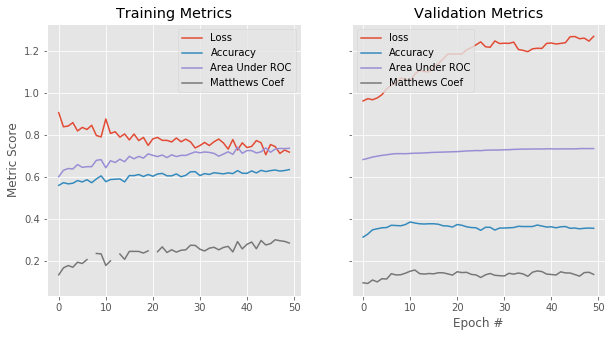

In [68]:
history_plotter(history=conv_history, n_epochs=50, plot_validation=True)

In [0]:
conv_model.load_weights(save_model_path)

# Object Detection via Transfer Learning


In [0]:
pretrained_mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet')
pretrained_mobilenet.trainable = False

In [0]:
mnet_lr = .000_01
mnet_model = tf.keras.models.Sequential()
mnet_model.add(pretrained_mobilenet)
mnet_model.add(tf.keras.layers.GlobalAveragePooling2D())
mnet_model.add(tf.keras.layers.Dense(64))
mnet_model.add(tf.keras.layers.Dropout(.5))
mnet_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

mnet_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=mnet_lr),
              loss=loss,
              metrics=METRICS)
mnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                81984     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 2,340,033
Trainable params: 82,049
Non-trainable params: 2,257,984
_________________________________________________________________


In [76]:
vdate_generator

In [0]:
if IN_COLAB:
    save_mnet_path = r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/models/mnet_classif_weights.hdf5'
    save_xc_path =  r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/models/xc_classif_weights.hdf5'
else:
    save_mnet_path = os.path.expanduser(r'~/Google Drive/thinkful/colab_datasets/sidewalk_data/models/mnet_classif_weights.hdf5')
    save_xc_path = os.path.expanduser(r'~/Google Drive/thinkful/colab_datasets/sidewalk_data/models/xc_classif_weights.hdf5')

checkp_params = dict(monitor='val_matthews_correlation', 
                         save_best_only=True, 
                         mode='max',
                         verbose=1)

cp_mnet = ModelCheckpoint(filepath=save_mnet_path, **checkp_params)
cp_xc = ModelCheckpoint(filepath=save_xc_path, **checkp_params)

fgen_params = dict(
                generator=train_generator, 
                steps_per_epoch=int(total_train_samples/batch_size),  
                verbose=1,
                validation_data=vdate_generator,
                validation_steps=int(total_vdate_samples/batch_size),
                class_weight=class_weight,
                use_multiprocessing=True
                )

In [0]:
mnet_history = mnet_model.fit_generator(epochs=50,
                                        callbacks=[cp_mnet],
                                        **fgen_params)

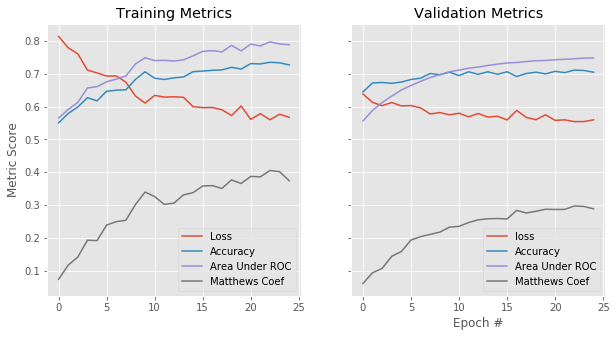

In [0]:
history_plotter(mnet_history)

In [84]:
pretrained_xception = tf.keras.applications.Xception(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet')
pretrained_xception.trainable = False

xc_lr = .000_01
xc_model = tf.keras.models.Sequential()
xc_model.add(pretrained_xception)
xc_model.add(tf.keras.layers.GlobalAveragePooling2D())
xc_model.add(tf.keras.layers.Dense(64))
xc_model.add(tf.keras.layers.Dropout(.5))
xc_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

xc_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=xc_lr),
              loss=loss,
              metrics=METRICS)
xc_model.summary()

83689472/83683744 [==============================] - 3s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 20,992,681
Trainable params: 131,201
Non-trainable params: 20,861,480
_________________________________________________________________


In [86]:
xc_epochs = 25
xc_history = xc_model.fit_generator(epochs=xc_epochs,
                                    callbacks=[cp_xc],
                                    **fgen_params)

Epoch 1/25
51/52 [============================>.] - ETA: 0s - loss: 0.7206 - accuracy: 0.5104 - auc: 0.5159 - matthews_correlation: 0.0048
Epoch 00001: val_matthews_correlation improved from -inf to 0.06807, saving model to /content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/models/xc_classif_weights.hdf5
52/52 [==============================] - 57s 1s/step - loss: 0.7193 - accuracy: 0.5105 - auc: 0.5161 - matthews_correlation: 0.0050 - val_loss: 0.7747 - val_accuracy: 0.3425 - val_auc: 0.5540 - val_matthews_correlation: 0.0681
Epoch 2/25
51/52 [============================>.] - ETA: 0s - loss: 0.6983 - accuracy: 0.5373 - auc: 0.5513 - matthews_correlation: 0.0479
Epoch 00002: val_matthews_correlation improved from 0.06807 to 0.09774, saving model to /content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/models/xc_classif_weights.hdf5
52/52 [==============================] - 61s 1s/step - loss: 0.6980 - accuracy: 0.5390 - auc: 0.5538 - matthews_correlation: 0.0509 - 

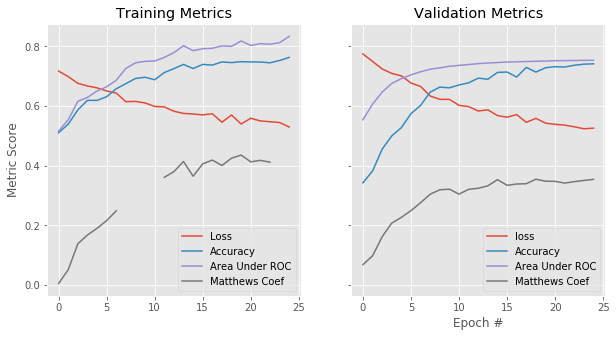

In [87]:
history_plotter(xc_history, n_epochs=xc_epochs)

# Test

In [0]:
xc_model.load(save_xc_path)
xc_model.predict(test_generator)